In [1]:
%pip install pandas seaborn scipy

Note: you may need to restart the kernel to use updated packages.


# Analysis Implementation

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from scipy import stats
import numpy as np
from packaging.version import Version

pd.options.mode.copy_on_write = True

# Define the specific version order
def version_sort_key(version):
    if version.startswith('OS'):
        priority = 0
    else:
        priority = 1
    return (priority, Version(version.split('-')[-1]))
    
def calculate_90th_percentile(df, value_column):
    """
    NOTE: Was generated using GPT-4o, so be careful with this function.
    
    Calculate the 90th percentile of a specific column, grouped by a combination of other columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        value_column (str): The name of the column to calculate the 90th percentile for.
    
    Returns:
        pd.DataFrame: A DataFrame with the grouped columns and their corresponding 90th percentile value.
    """
    # Define the columns to group by
    group_columns = [
        'environment', 'engine_version', 'task', 'workload', 'operation', 'name', 'meta.tag_run'
    ]
    
    # Group by the specified columns and calculate the 90th percentile
    result = df.groupby(group_columns)[value_column].quantile(0.9).reset_index()
    
    # Rename the quantile column for clarity
    # Here, we create our own p90 column to compare
    result.rename(columns={value_column: 'value\\.90_0'}, inplace=True)
    
    return result
    
def print_performance_summary(df, column_name):
    print("Performance Summary Across Tasks")
    print("=" * 120)
    
    results = []
    # Sort versions in the specified order
    all_versions = sorted(df['engine_version'].unique(), key=version_sort_key)
    
    for task in sorted(df['task'].unique()):
        task_data = df[df['task'] == task]
        
        # Calculate statistics for each version
        version_stats = {}
        for version in all_versions:
            version_data = task_data[task_data['engine_version'] == version][column_name]
            if len(version_data) > 0:
                version_stats[version] = {
                    'mean': version_data.mean(),
                    'samples': len(version_data)
                }
        
        # Find ES version for baseline
        es_versions = [v for v in version_stats.keys() if v.startswith('ES')]
        if es_versions and version_stats:
            baseline_version = es_versions[-1]  # Use most recent ES version as baseline
            baseline_mean = version_stats[baseline_version]['mean']
            
            # Calculate statistics for all versions
            st = {}
            for version, data in version_stats.items():
                if version == baseline_version:
                    st[version] = {
                        'mean': data['mean'],
                        'samples': data['samples'],
                        'is_baseline': True,
                        'percent_diff': 0,
                        'p_value': 1.0
                    }
                else:
                    percent_diff = ((data['mean'] - baseline_mean) / baseline_mean) * 100
                    _, p_value = stats.mannwhitneyu(
                        task_data[task_data['engine_version'] == version][column_name],
                        task_data[task_data['engine_version'] == baseline_version][column_name],
                        alternative='two-sided'
                    )
                    st[version] = {
                        'mean': data['mean'],
                        'samples': data['samples'],
                        'is_baseline': False,
                        'percent_diff': percent_diff,
                        'p_value': p_value
                    }
            
            results.append({
                'task': task,
                'stats': st
            })
    
    # Print header
    header = ['Task']
    for version in all_versions:
        header.append(version)
    
    # Calculate column widths
    task_width = 65
    version_width = 32
    
    # Print header
    print(f"{header[0]:<{task_width}}", end='')
    for version in all_versions:
        print(f"{version:<{version_width}}", end='')
    print()
    print("-" * (task_width + version_width * len(all_versions)))
    
    # Print results
    for r in results:
        print(f"{r['task']:<{task_width}}", end='')
        for version in all_versions:
            if version in r['stats']:
                st = r['stats'][version]
                if st['is_baseline']:
                    cell = f"{st['mean']:.3f}ms (baseline, n={st['samples']})"
                else:
                    if st['p_value'] < 0.05:
                        # Show faster/slower compared to ES
                        faster_slower = "faster" if st['percent_diff'] < 0 else "slower"
                        cell = f"{st['mean']:.3f}ms ({abs(st['percent_diff']):.1f}% {faster_slower}, n={st['samples']})"
                    else:
                        cell = f"{st['mean']:.3f}ms (similar, n={st['samples']})"
            else:
                cell = "N/A"
            print(f"{cell:<{version_width}}", end='')
        print()
    
    print("\nNote: Percentages show how much faster/slower each version is compared to ES (baseline)")
    print("      'similar' means the difference is not statistically significant (p>=0.05)")
    print("      'baseline' indicates the ES version used for comparison")
    print("      'n' shows the number of samples for each version")
    print()
    print()
    
def create_boxplots(df,column_name):
    tasks = df['task'].unique()
    n_tasks = len(tasks)
    n_rows = (n_tasks - 1) // 3 + 1
    
    # Sort engine versions consistently
    engine_versions = sorted(df['engine_version'].unique(), key=version_sort_key)
    
    color_map = {}
    os_versions = [v for v in engine_versions if v.startswith('OS')]
    for idx, version in enumerate(engine_versions):
        if version.startswith('ES'):
            color_map[version] = '#ff6b6b'  # Red for ES
        else:
            # Get position within OS versions for shade of blue
            os_idx = os_versions.index(version)
            # Create different shades of blue for OS versions
            color_map[version] = plt.cm.Blues(0.5 + os_idx * 0.2)
    
    # Create subplot grid
    fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    
    # Add boxplots one by one
    for idx, task in enumerate(sorted(tasks)):
        task_data = df[df['task'] == task]
        
        # Convert engine_version to categorical with desired order
        task_data['engine_version'] = pd.Categorical(
            task_data['engine_version'],
            categories=engine_versions,
            ordered=True
        )
        
        # Create box plot with different versions and colors
        sns.boxplot(data=task_data, 
                   x='engine_version', 
                   y=column_name,
                   hue='engine_version',
                   palette=color_map,
                   legend=False,
                   ax=axes[idx])
        
        # Rotate x-axis labels for better readability
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].set_xlabel('')  # Remove x-axis label
        
        axes[idx].set_title(f'{task}')
        axes[idx].set_ylabel('Time (seconds) - p90')
        
    # Remove any extra subplots
    for idx in range(len(tasks), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig

def load_and_process_csvs(directory_path):
    # Get all CSV files in the directory
    csv_files = glob.glob(directory_path)
    
    # Read and concatenate all CSV files
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        dfs.append(df)
    
    df = pd.concat(dfs, ignore_index=True)

    # Extract engine type and version
    df['engine'] = df['meta.tag_engine-type']
    df['version'] = df['meta.distribution_version']
    # Combine engine and version for display
    df['engine_version'] = df['engine'] + '-' + df['version']

    # Since this is raw data, calculate what the 90th percentile is (can compare this to OSB)
    p90 = calculate_90th_percentile(df,'value (milliseconds)')
    
    return df,p90

def analyze_performance(df,column):
    print_performance_summary(df,column)
    fig = create_boxplots(df,column)
    plt.show()

def filter_by_workload(df, workload):
    # First filter by workload
    res = df[df['workload'] == workload].copy()
    
    # Create a combined workload-operation identifier
    res['task'] = res['workload'] + ' / ' + res['task']
    
    return res

In [4]:
df,p90 = load_and_process_csvs("opensearch_data_2024-11-30_2024-12-18.csv")

In [5]:
def filter_recent_data(df, start_date='2024-12-01'):
    """
    Filter DataFrame to only include rows after a specific date.
    Handles Unix timestamps in milliseconds.
    
    Args:
        df: DataFrame containing performance data with Unix timestamps in milliseconds
        start_date: Start date in 'YYYY-MM-DD' format (default: '2024-12-01')
    
    Returns:
        DataFrame containing only rows after the start date
    """
    # Convert start_date to Unix timestamp in milliseconds
    start_timestamp = int(pd.to_datetime(start_date).timestamp() * 1000)

    timestamp_key = 'Timestamp (unix epoch)'
    
    # Filter the data
    filtered_df = df[df[timestamp_key] >= start_timestamp].copy()
    
    # Print summary of filtering
    total_rows = len(df)
    filtered_rows = len(filtered_df)
    removed_rows = total_rows - filtered_rows
    
    # Convert some example timestamps for verification
    if not filtered_df.empty:
        min_time = pd.to_datetime(filtered_df[timestamp_key].min(), unit='ms')
        max_time = pd.to_datetime(filtered_df[timestamp_key].max(), unit='ms')
        print(f"\nFiltering Summary:")
        print(f"Start date: {start_date}")
        print(f"Date range in filtered data: {min_time} to {max_time}")
        print(f"Total rows: {total_rows:,}")
        print(f"Rows after {start_date}: {filtered_rows:,}")
        print(f"Rows removed: {removed_rows:,} ({removed_rows/total_rows*100:.1f}%)")
    else:
        print(f"\nNo data found after {start_date}")
    
    return filtered_df

In [6]:
data_df = filter_recent_data(df, '2024-12-05')
df = data_df


Filtering Summary:
Start date: 2024-12-05
Date range in filtered data: 2024-12-05 00:21:02.637000 to 2024-12-10 14:39:07.370000
Total rows: 19,538,582
Rows after 2024-12-05: 5,697,456
Rows removed: 13,841,126 (70.8%)


# Workload Results (all data)

Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
big5 / asc_sort_timestamp                                        4.888ms (78.7% faster, n=7200)  4.974ms (78.3% faster, n=7200)  5.114ms (77.7% faster, n=7200)  22.929ms (baseline, n=7200)     
big5 / asc_sort_timestamp_can_match_shortcut                     4.949ms (73.9% faster, n=7200)  5.053ms (73.3% faster, n=7200)  5.311ms (72.0% faster, n=7200)  18.939ms (baseline, n=7200)     
big5 / asc_sort_timestamp_no_can_match_shortcut                  4.979ms (73.7% faster, n=7200)  5.069ms (73.2% faster, n=7200)  5.306ms (72.0% faster, n=7200)  18.940ms (baseline, n=7200)   

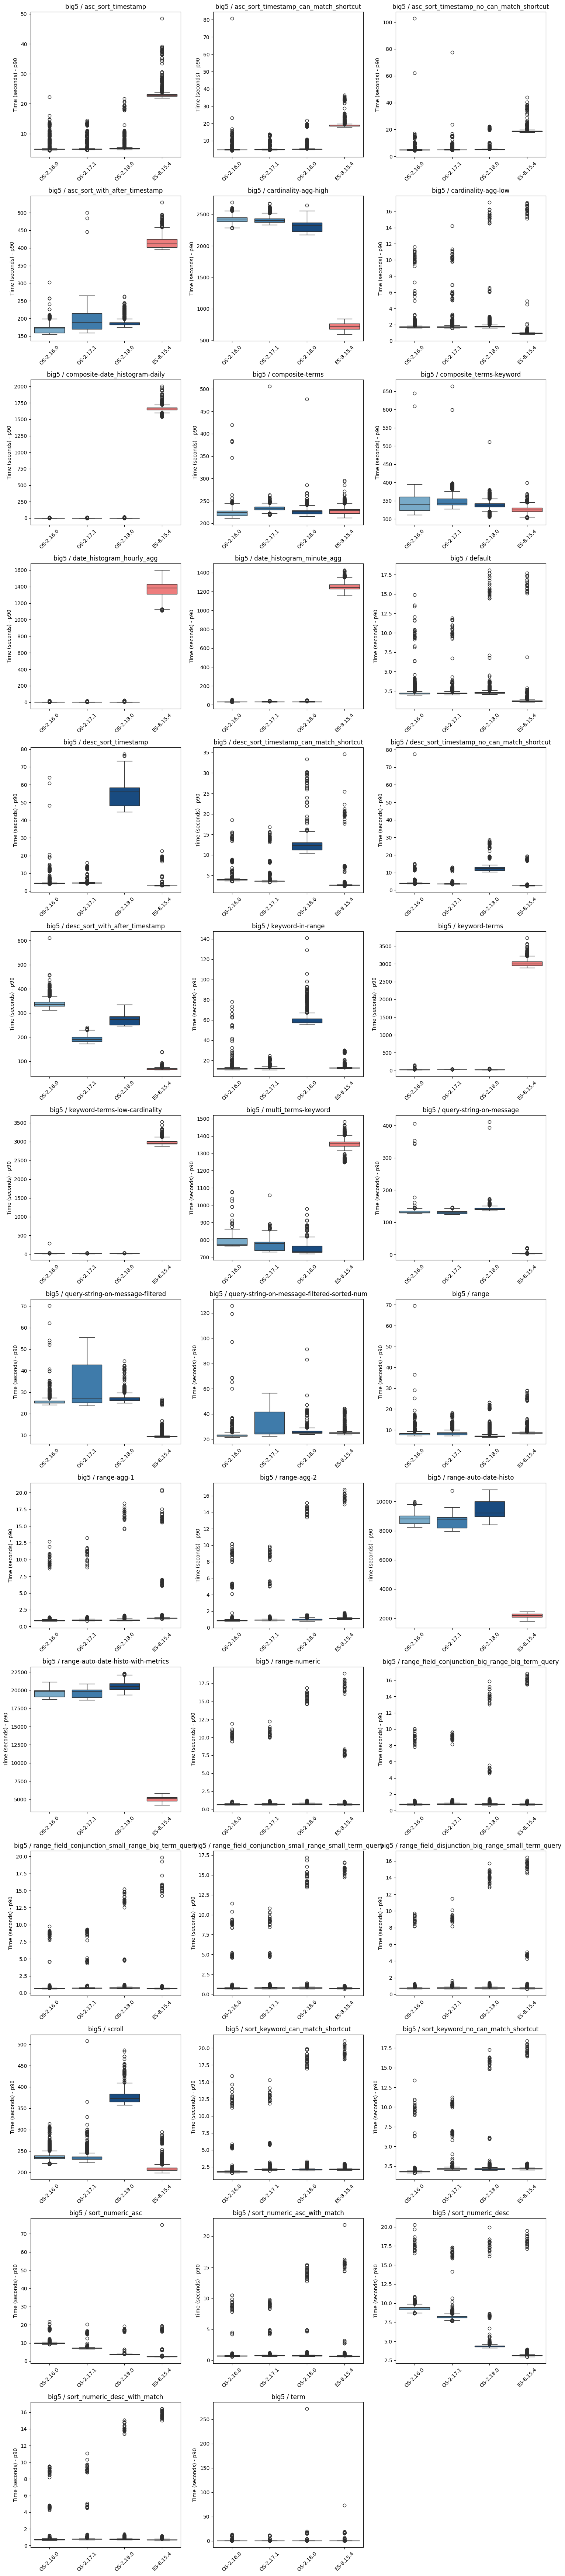



Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
nyc_taxis / asc_sort_tip_amount                                  2.908ms (100.0% faster, n=3600) 2.845ms (100.0% faster, n=3600) 3.166ms (99.9% faster, n=3600)  6248.005ms (baseline, n=3600)   
nyc_taxis / autohisto_agg                                        3.401ms (98.8% faster, n=3600)  3.318ms (98.8% faster, n=3600)  3.657ms (98.7% faster, n=3600)  274.009ms (baseline, n=3600)    
nyc_taxis / date_histogram_agg                                   3.304ms (10.4% faster, n=3600)  3.273ms (11.3% faster, n=3600)  3.596ms (2.5% faster, n=3600)   3.689ms (baseline, n=3600)  

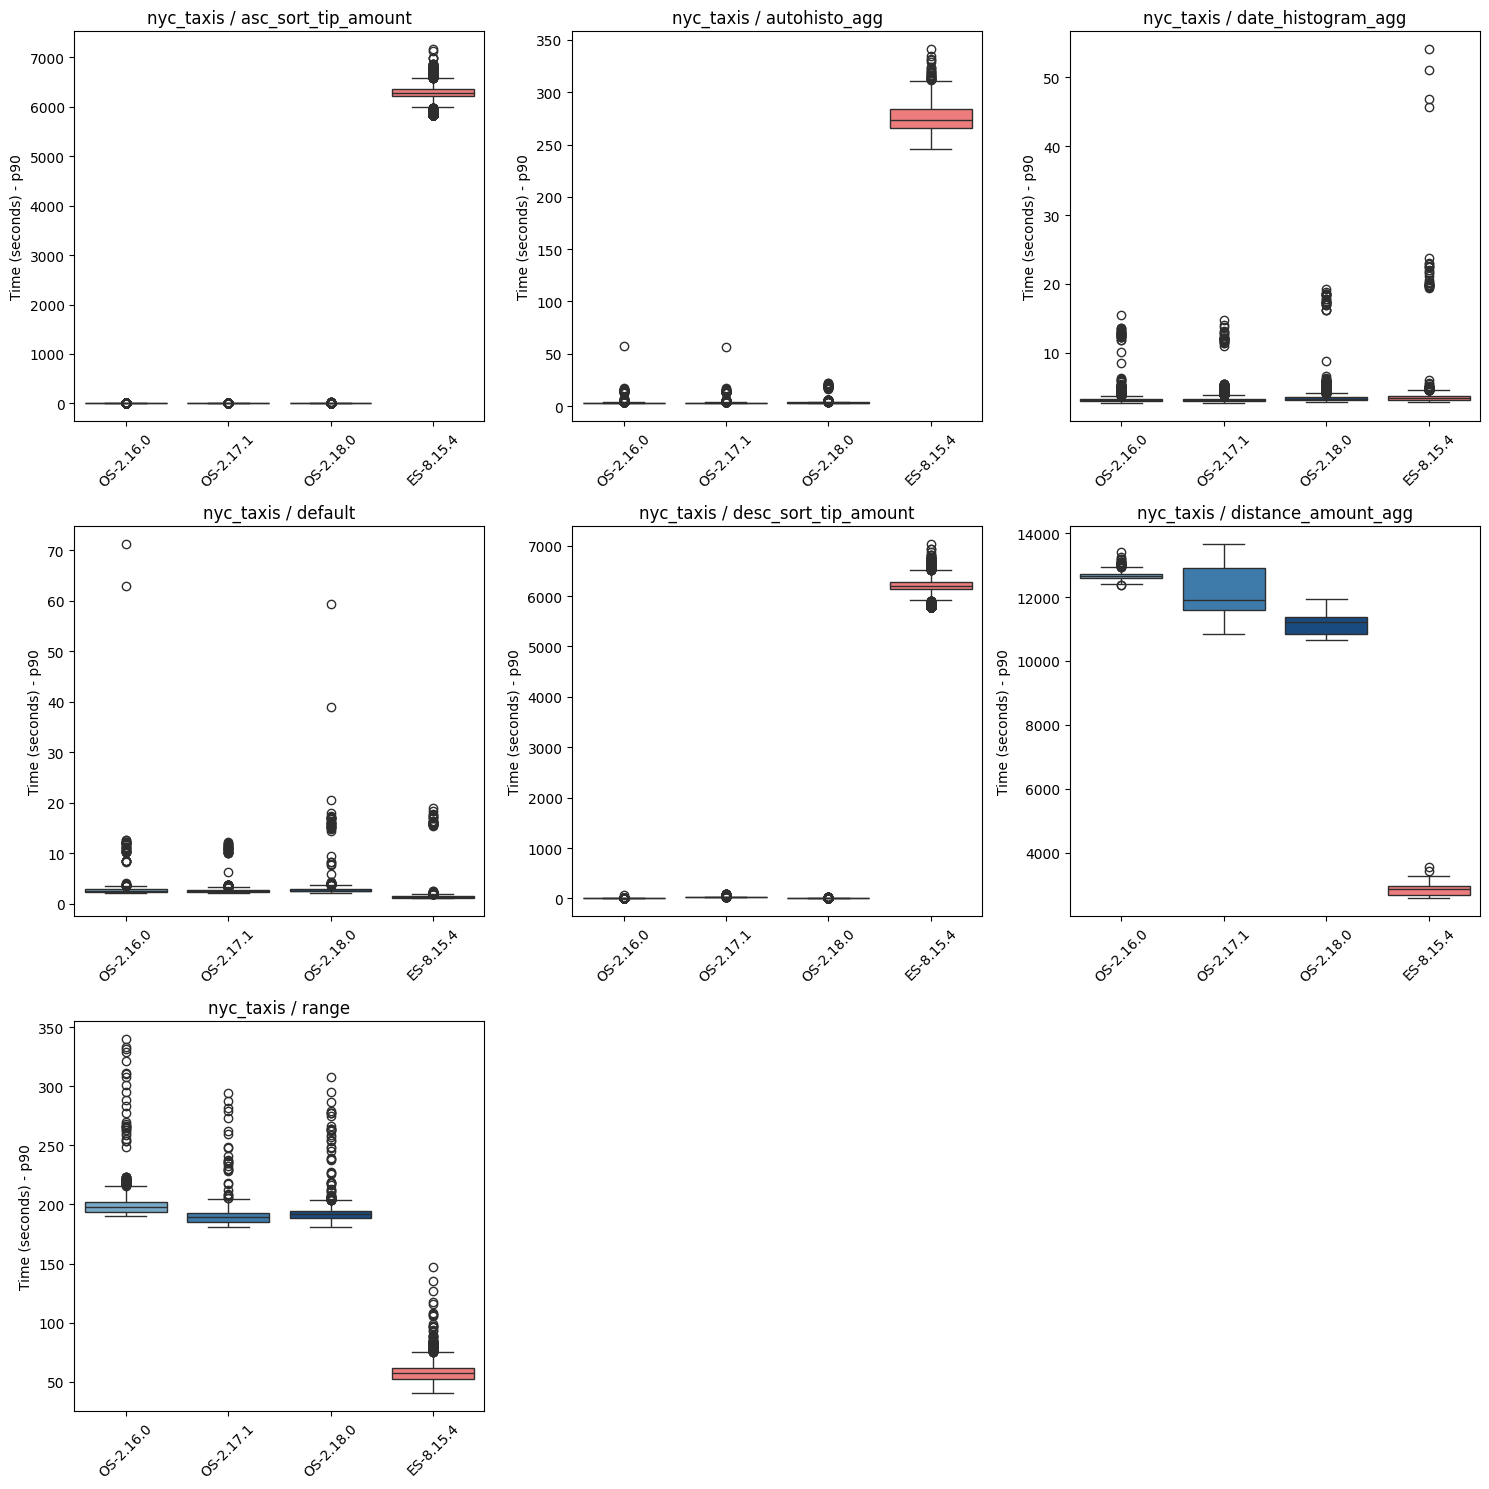



Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pmc / articles_monthly_agg_cached                                1.349ms (23.5% slower, n=16800) 1.433ms (31.2% slower, n=16800) 1.586ms (45.1% slower, n=16800) 1.092ms (baseline, n=16800)     
pmc / articles_monthly_agg_uncached                              5.524ms (11.1% faster, n=16800) 5.511ms (11.4% faster, n=16800) 6.338ms (1.9% slower, n=16800)  6.217ms (baseline, n=16800)     
pmc / default                                                    2.477ms (4.9% faster, n=16800)  2.624ms (0.7% slower, n=16800)  4.272ms (64.0% slower, n=16800) 2.605ms (baseline, n=16800) 

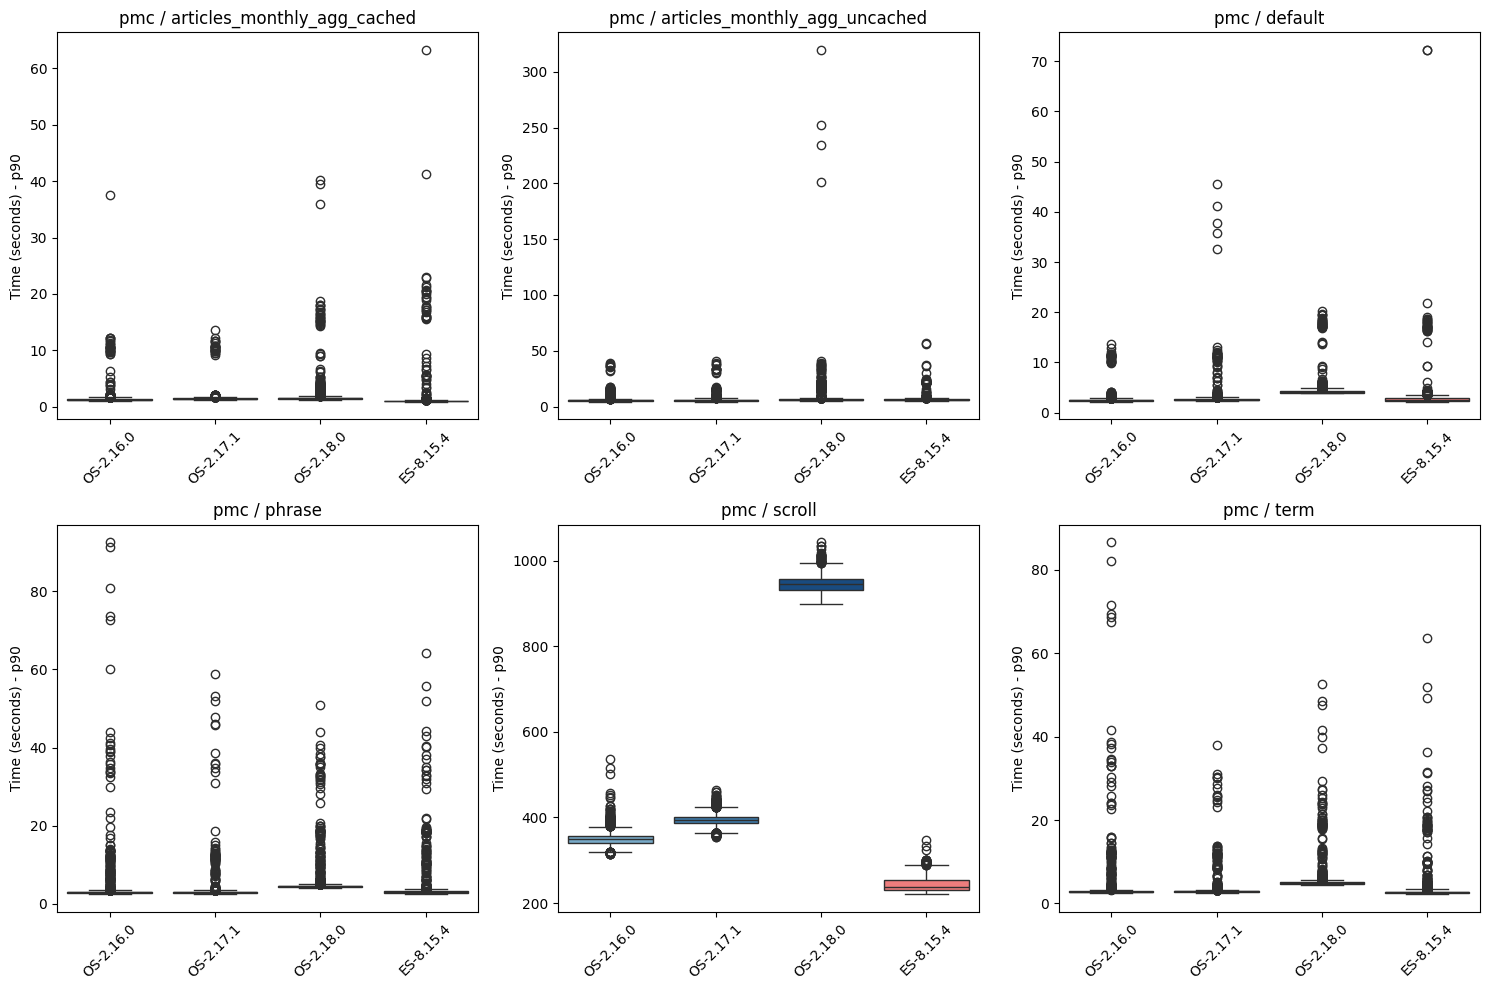



Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.4                       
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
noaa / date-histo-entire-range                                   1.582ms (16.8% faster, n=14400) 1.720ms (9.5% faster, n=14400)  1.725ms (9.2% faster, n=14400)  1.901ms (baseline, n=14400)     
noaa / date-histo-geohash-grid                                   1436.526ms (346.6% slower, n=1440)1381.464ms (329.5% slower, n=1440)1366.642ms (324.8% slower, n=1440)321.678ms (baseline, n=1440)    
noaa / date-histo-geotile-grid                                   1882.330ms (434.5% slower, n=1440)1817.442ms (416.1% slower, n=1440)1807.833ms (413.3% slower, n=1440)352.168ms (basel

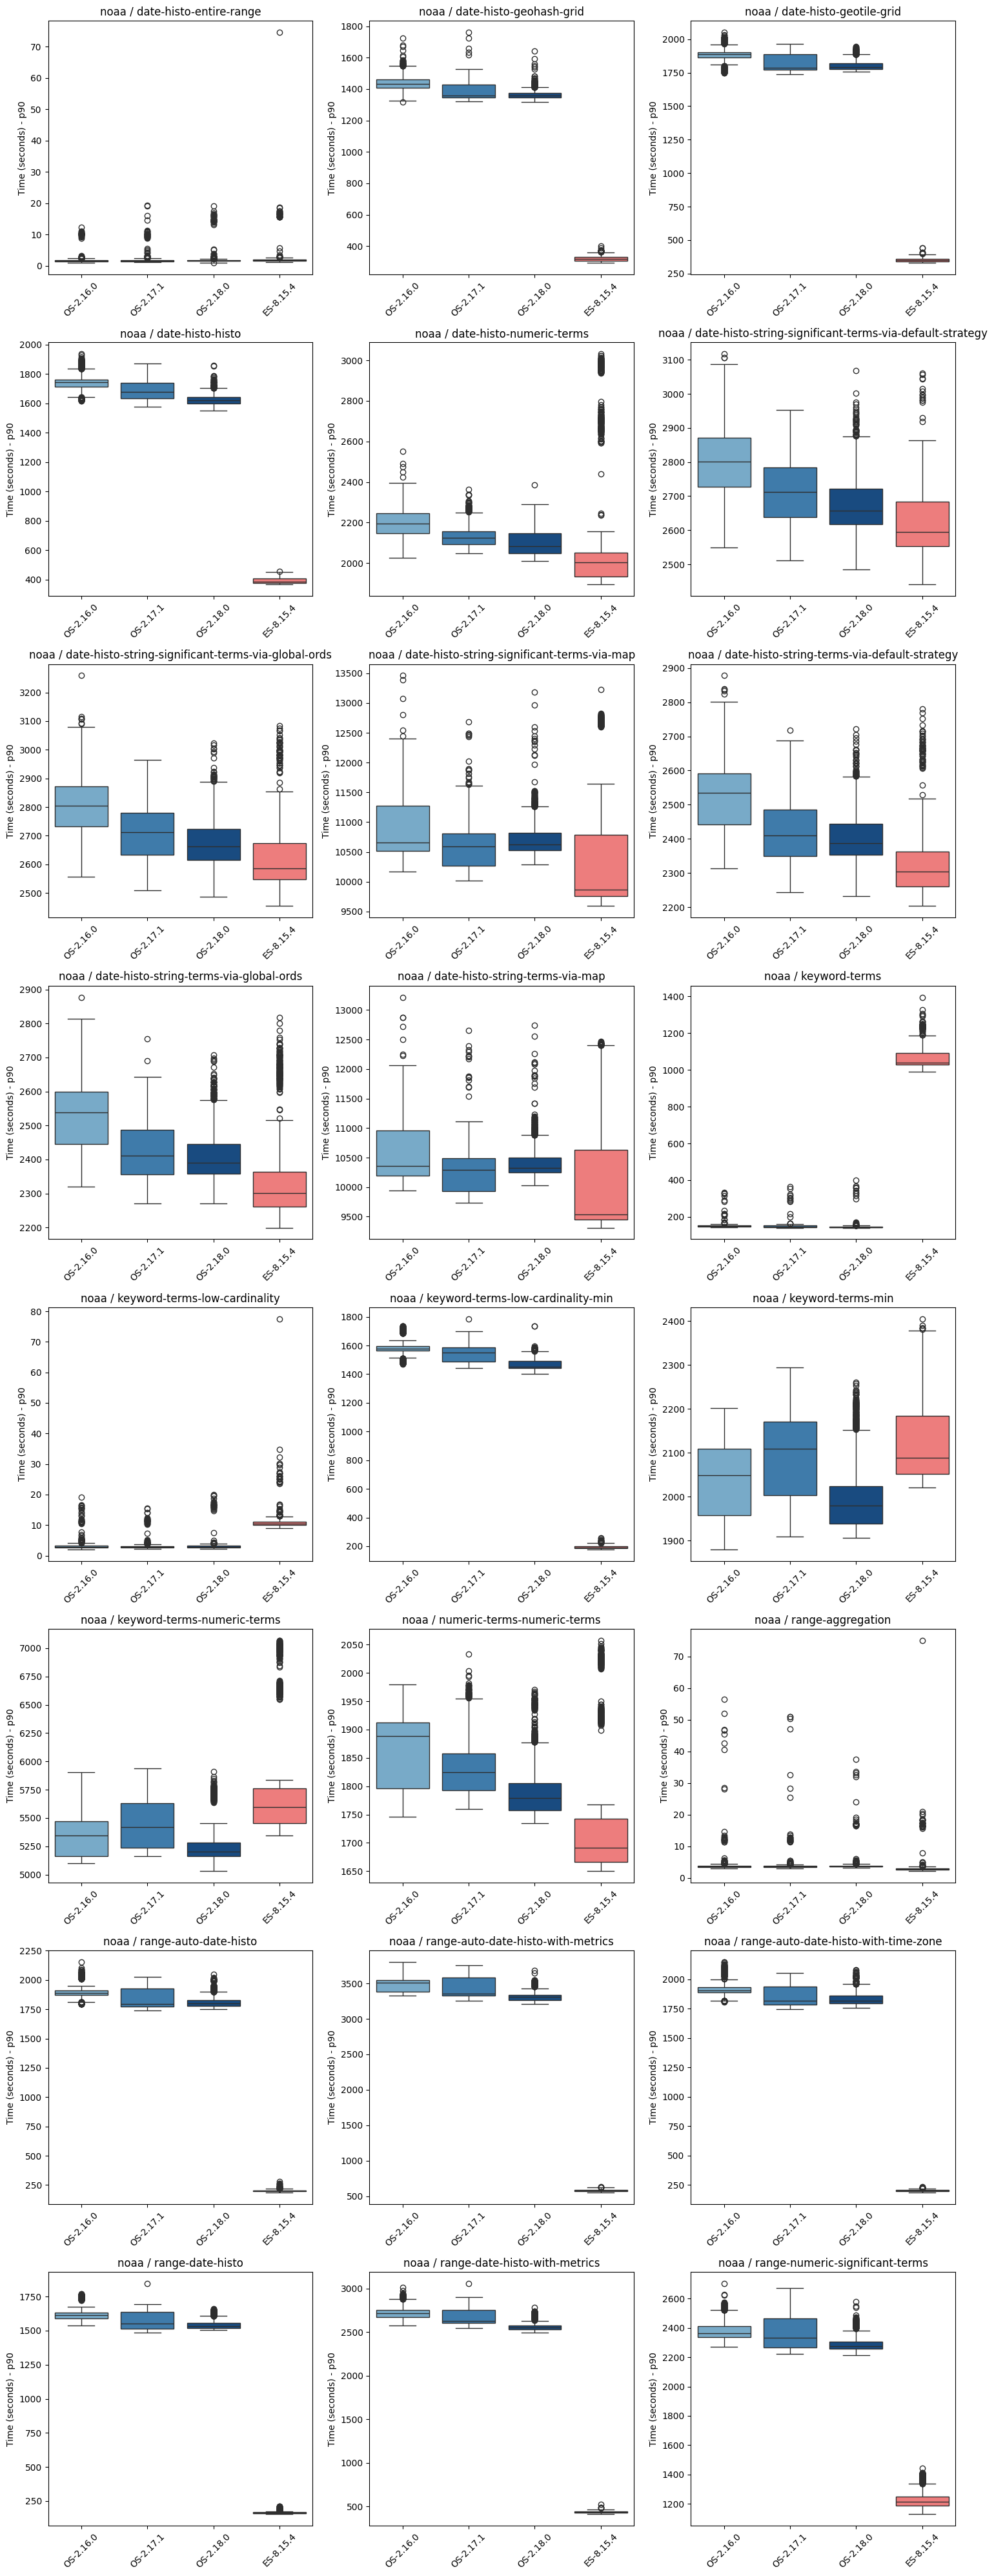

In [ ]:
for workload in ["big5", "nyc_taxis", "pmc", "noaa"]:
    workload_df = filter_by_workload(df, workload)
    analyze_performance(workload_df,"value")
    print()
    print()

# Workload Results (90th percentile)

# pmc - p90th
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.0                       ES-8.15.4                       
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pmc / articles_monthly_agg_cached                                1.423ms (27.5% slower, n=96)    1.507ms (35.1% slower, n=12)    1.519ms (36.1% slower, n=76)    1.560ms (39.8% slower, n=88)    1.120ms (similar, n=20)         1.116ms (baseline, n=76)        
pmc / articles_monthly_agg_uncached                              5.833ms (11.0% faster, n=96)    6.146ms (6.2% faster, n=12)     5.956ms (9.1% faster, n=76)     6.646ms (1.4% slow

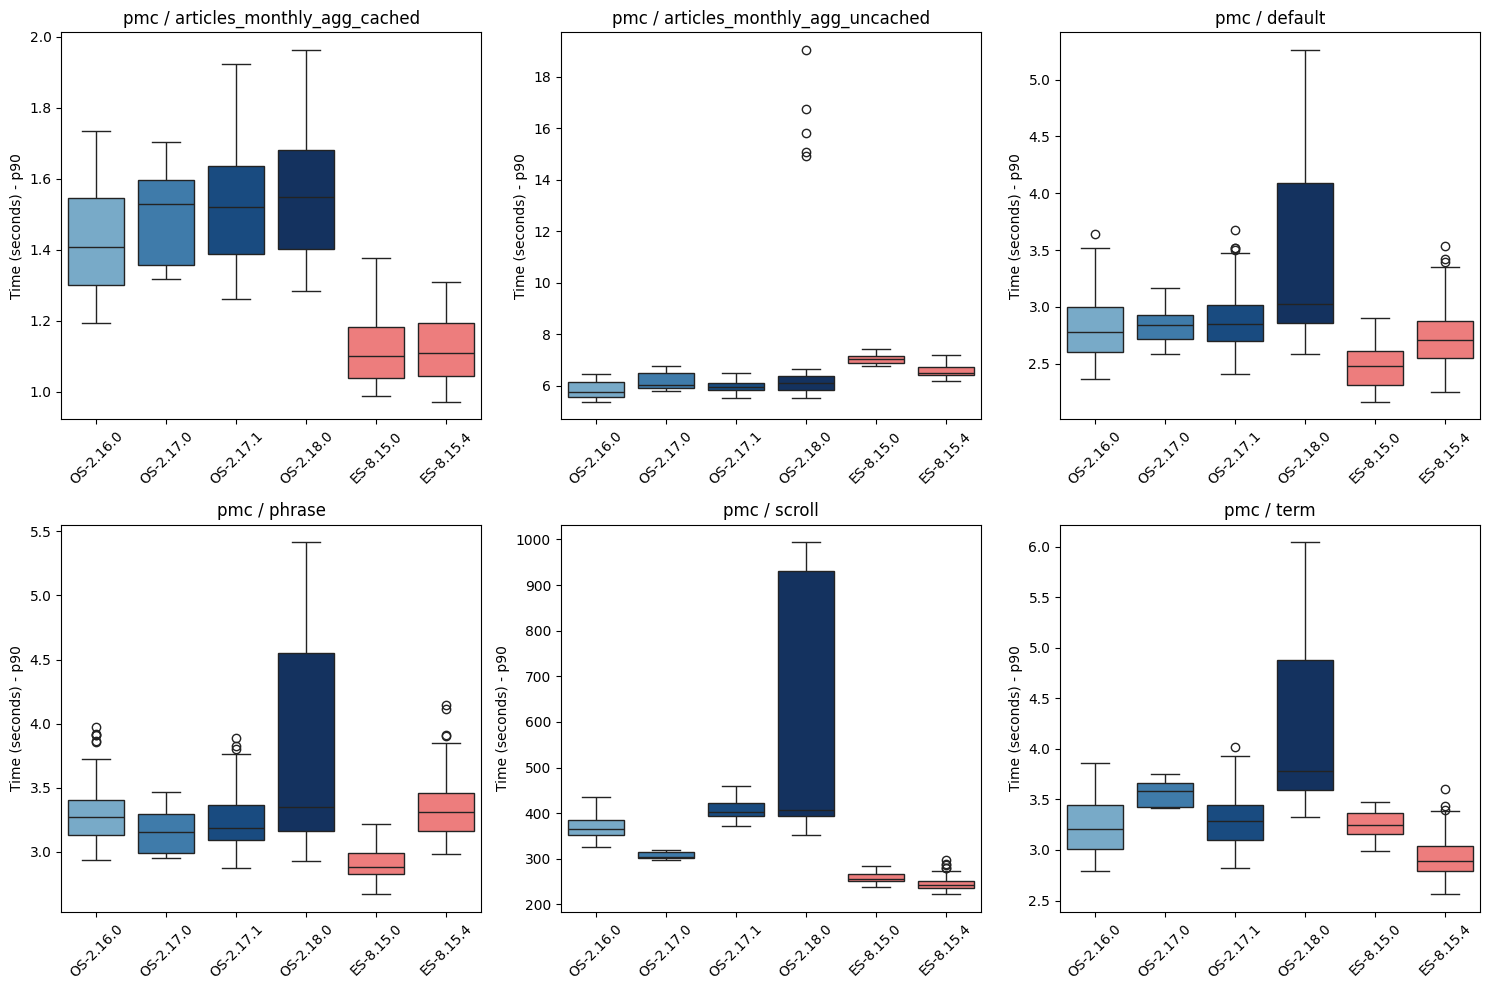



# noaa - p90th
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.0                       ES-8.15.4                       
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
noaa / date-histo-entire-range                                   1.892ms (5.1% faster, n=96)     1.913ms (4.0% faster, n=72)     1.917ms (similar, n=80)         2.030ms (similar, n=20)         1.994ms (baseline, n=72)        
noaa / date-histo-geohash-grid                                   1430.844ms (335.6% slower, n=96)1394.281ms (324.5% slower, n=72)1391.367ms (323.6% slower, n=80)329.588ms (similar, n=20)       328.461ms (baseline, n=72)      
noaa / date-histo-geotile-grid                

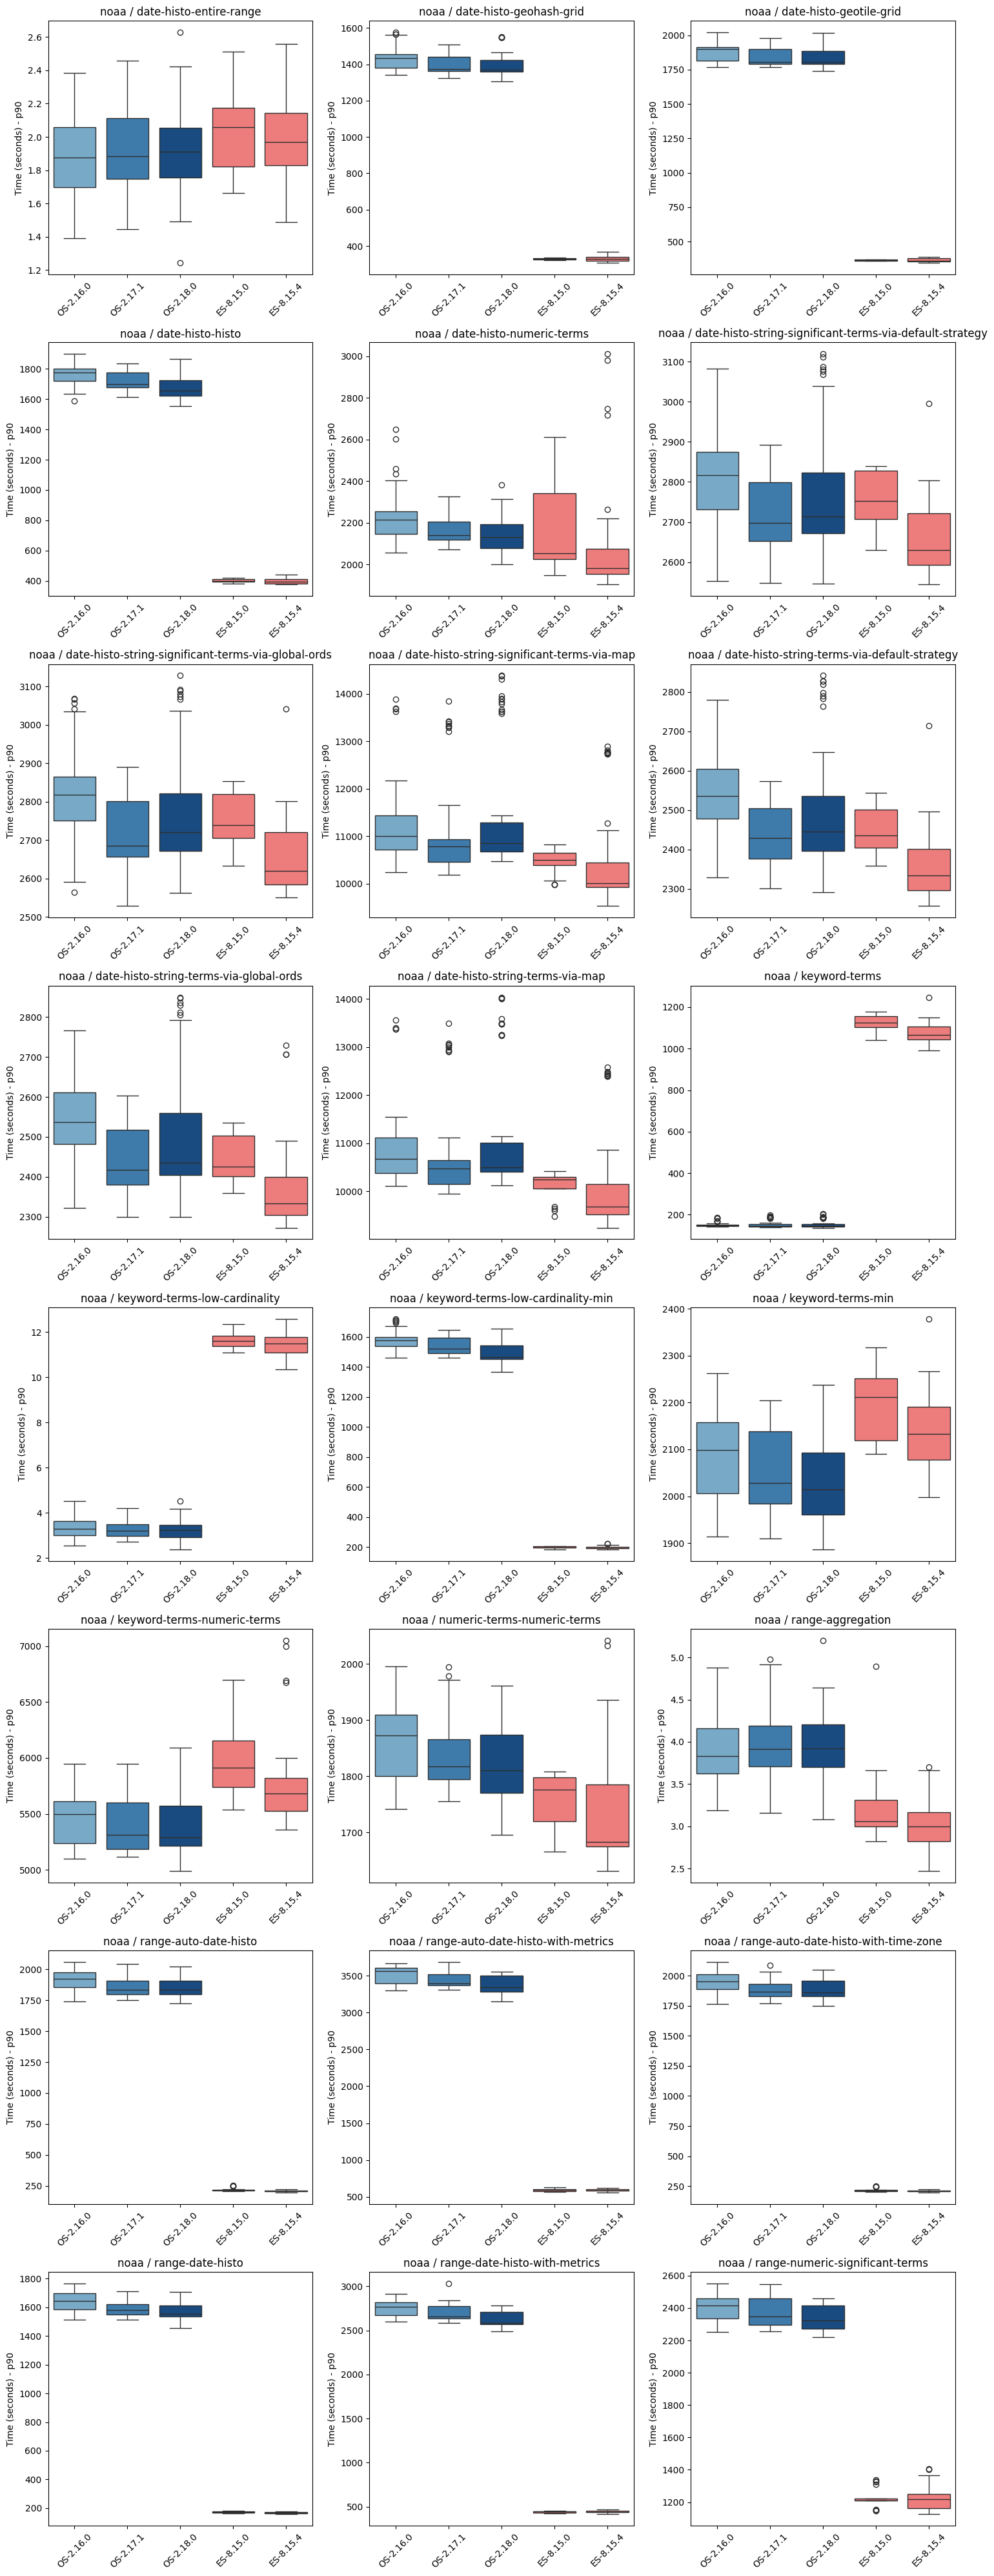



# nyc_taxis - p90th
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.0                       ES-8.15.4                       
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
nyc_taxis / asc_sort_tip_amount                                  2.950ms (100.0% faster, n=96)   2.955ms (100.0% faster, n=76)   3.145ms (99.9% faster, n=92)    6260.325ms (similar, n=20)      6156.548ms (baseline, n=76)     
nyc_taxis / autohisto_agg                                        3.657ms (98.7% faster, n=96)    3.592ms (98.7% faster, n=76)    3.901ms (98.6% faster, n=92)    307.349ms (10.7% slower, n=20)  277.540ms (baseline, n=76)      
nyc_taxis / date_histogram_agg           

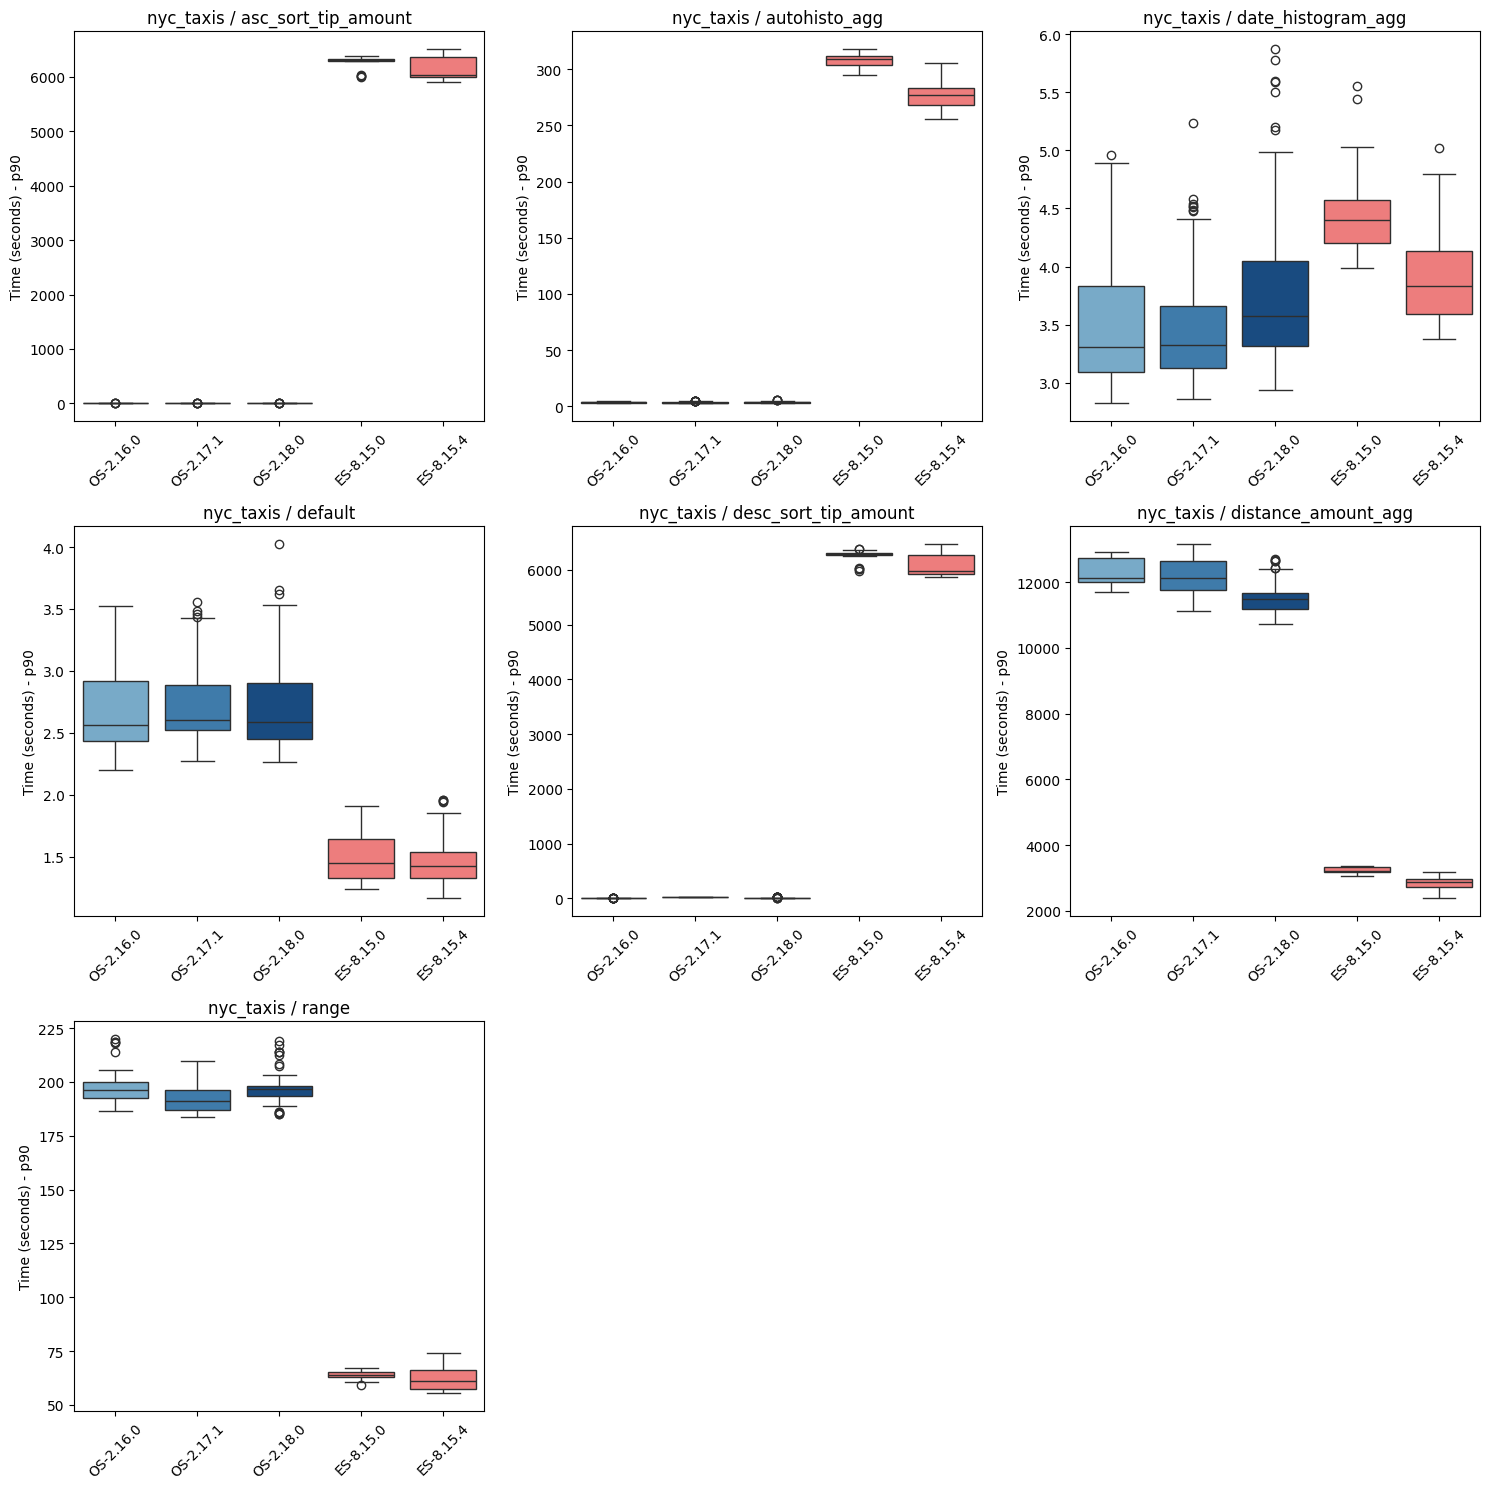



# big5 - p90th
Performance Summary Across Tasks
Task                                                             OS-2.16.0                       OS-2.17.0                       OS-2.17.1                       OS-2.18.0                       ES-8.15.0                       ES-8.15.4                       
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
big5 / asc_sort_timestamp                                        4.891ms (78.7% faster, n=103)   104.889ms (356.2% slower, n=12) 5.007ms (78.2% faster, n=72)    5.036ms (78.1% faster, n=80)    23.619ms (2.7% slower, n=24)    22.992ms (baseline, n=80)       
big5 / asc_sort_timestamp_can_match_shortcut                     4.930ms (74.0% faster, n=103)   21.468ms (13.4% slower, n=12)   5.063ms (73.3% faster, n=72)    5.251ms (72.3% 

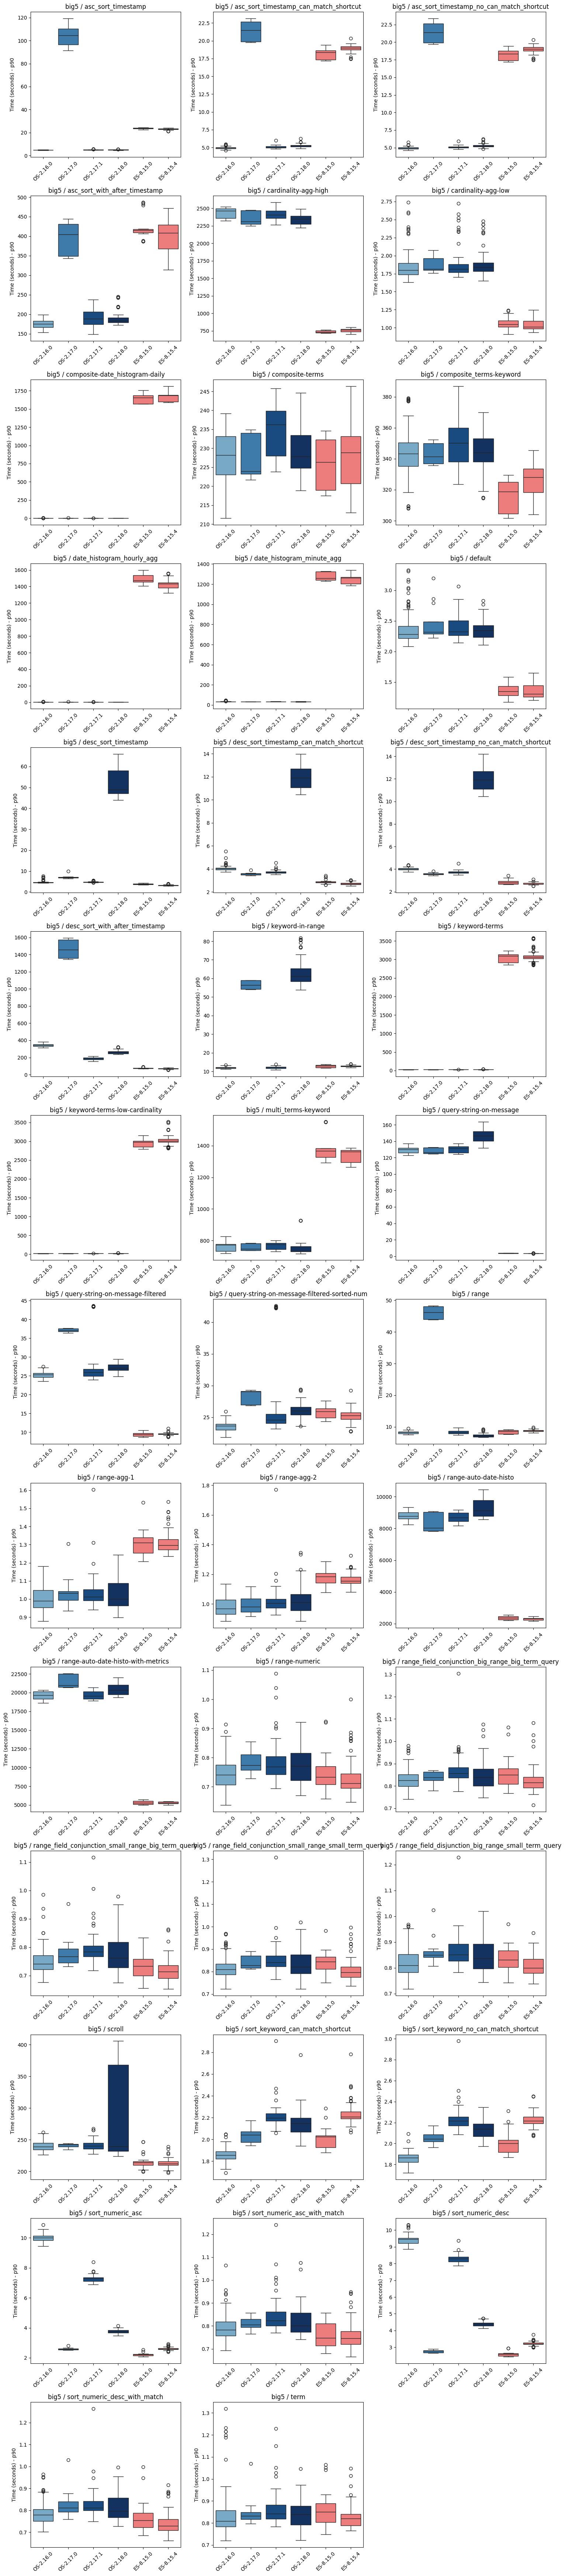

In [8]:
for workload in ["pmc", "noaa", "nyc_taxis", "big5"]:
    print(f"# {workload} - p90th")
    workload_df = filter_by_workload(p90, workload)
    analyze_performance(workload_df, "value\\.90_0")
    print()
    print()